In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [4]:
groups = pd.read_csv('gdrive/My Drive/Colab Notebooks/uchi/groups.csv', sep=';',index_col='id')
groups.sort_values(by ='id').head()

,grp
id,
1489,B
1627,A
1768,B
1783,B
1794,A


In [5]:
groups.shape

(74576, 1)

Количество человек в контрольной А-группе и целевой В-группе

In [6]:
groups.grp.value_counts()*100/groups.shape[0]

B    80.297951
A    19.702049
Name: grp, dtype: float64

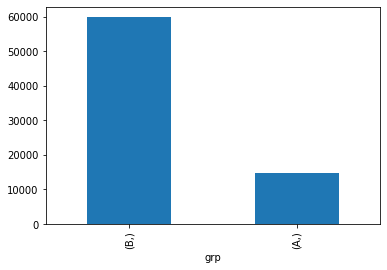

In [7]:
groups.value_counts().plot(kind='bar', label='Group');

обычно на практике встречал разделение на две примерно равные группы


 файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [8]:
active_studs = pd.read_csv('gdrive/My Drive/Colab Notebooks/uchi/active_studs.csv', sep=';')
active_studs.sort_values(by ='student_id').head()

,student_id
4412,1627
7887,2085
3144,2215
3040,3391
3851,3401


In [9]:
active_studs.student_id.nunique()

8341

файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [10]:
checks = pd.read_csv('gdrive/My Drive/Colab Notebooks/uchi/checks.csv', sep=';')
checks.sort_values(by ='student_id').head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [11]:
checks.student_id.nunique()

541

количесвто пользователей, заходивших на платформы в дни проведения эксперимента = 8341 

сколько человек оплачивало в контрольный период = 541 

объединим таблицы с данными по группам и данными по id юзеров


объединим таблицы с id пользователей разделенных на группы и таблицей транзакций

In [12]:
groups_check = groups.merge(checks, left_on='id', right_on='student_id', sort = True)
groups_check.head()

,grp,student_id,rev
0,A,1627,990.0
1,B,3185,690.0
2,B,25973,690.0
3,B,26280,690.0
4,B,100300,990.0


а теперь объединим полученную таблицу с таблицей данных об активных в момент проведения теста юзерах

In [13]:
active_studs_checks = active_studs.merge(groups_check, left_on='student_id', right_on='student_id', sort = True)
active_studs_checks.head()

,student_id,grp,rev
0,1627,A,990.0000
1,100300,B,990.0000
2,108270,B,290.0000
3,264473,B,1900.0001
4,274352,B,690.0000


In [14]:
active_studs_checks.shape

(392, 3)

In [15]:
active_studs_checks.grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

также сделаем таблицу, где вместе id активных во время теста юзеров и их принадлежность к группам

In [16]:
active_studs_groups = active_studs.merge(groups, left_on='student_id', right_on='id', sort = True)
active_studs_groups.head()

,student_id,grp
0,1627,A
1,2085,B
2,2215,B
3,3391,A
4,3401,B


In [17]:
active_studs_groups.shape

(8341, 2)

In [18]:
active_studs_groups.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

**На какие метрики Вы смотрите в ходе анализа и почему?**

Посмотрим на размер среднего чека для групп, также посмотрим на долю пользователей с оплатами из общего числа отнесенных к группам

Мы хотим увидеть увеличение среднего чека в целевой группе

Также необходимо проконтролировать увеличилось ли число юзеров с транзакциями 
в целевой группе

процент юзеров из обеих групп, что были активны в период теста и у них были 
транзакции

In [19]:
(active_studs_checks.grp.value_counts())*100/(active_studs_groups.grp.value_counts())

B    4.615611
A    5.071521
Name: grp, dtype: float64

In [20]:
num_a, num_b = 1538, 6803
click_a, click_b = 78, 314
rate_a, rate_b = click_a / num_a, click_b / num_b

построим распределения для обеих групп, сначала биноминальное, а затем и нормальное

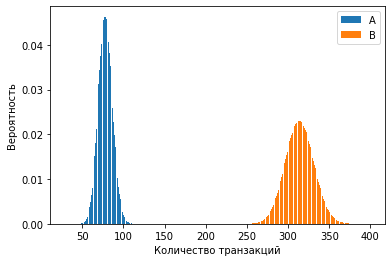

In [21]:
from scipy.stats import binom
import numpy as np

# вероятность
clicks = np.arange(30, 400)
prob_a = binom(num_a, rate_a).pmf(clicks)
prob_b = binom(num_b, rate_b).pmf(clicks)

plt.bar(clicks, prob_a, label="A")
plt.bar(clicks, prob_b, label="B")
plt.legend()
plt.xlabel("Количество транзакций"); plt.ylabel("Вероятность");

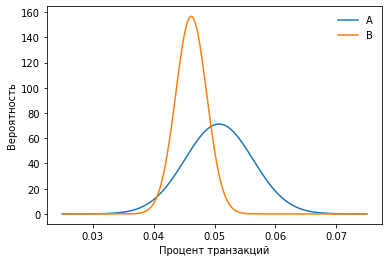

In [22]:
from scipy.stats import norm

std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)

click_rate = np.linspace(0.025, 0.075, 200)
prob_a = norm(rate_a, std_a).pdf(click_rate)
prob_b = norm(rate_b, std_b).pdf(click_rate)

plt.plot(click_rate, prob_a, label="A")
plt.plot(click_rate, prob_b, label="B")
plt.legend(frameon=False)
plt.xlabel("Процент транзакций"); plt.ylabel("Вероятность");

оценим p-value, z-score, статистическую мощность (statistical power)

zscore = -0.742, p-value = 0.771


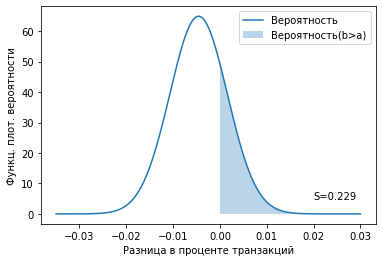

In [23]:
z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
p = norm(rate_b - rate_a, np.sqrt(std_a**2 + std_b**2))

x = np.linspace(-0.035, 0.03, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="Вероятность")
plt.fill_between(x, 0, y, where=x>0, label="Вероятность(b>a)", alpha=0.3)
plt.annotate(f"S={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Разница в проценте транзакций"); plt.ylabel("Функц. плот. вероятности");

print(f"zscore = {z_score:0.3f}, p-value = {norm().sf(z_score):0.3f}")

можем увидеть что результат не является статистически значимым

**Являются ли эти различия статистически значимыми?**

можем увидеть что процент юзеров с транзакциями в целевой группе меньше на 0.45%

результат не является статистически значимым,
процент пользователей с конверсиями практически не изменился **для данного размера выборки**

**посмотрим на медианный и средний чек**

In [24]:
active_studs_checks.groupby('grp').rev.median()

grp
A     585.0
B    1140.0
Name: rev, dtype: float64

In [25]:
active_studs_checks.groupby('grp').rev.mean()

grp
A     933.589744
B    1257.878992
Name: rev, dtype: float64

**Имеются ли различия в показателях и с чем они могут быть связаны?**

Сумма медианного чека в контрольной группе выше почти в два раза!

Это может быть связано с удобством новой системы оплаты... **но попробуем посмотреть внимательнее**

взглянем на распределение сумм по чекам для обеих групп


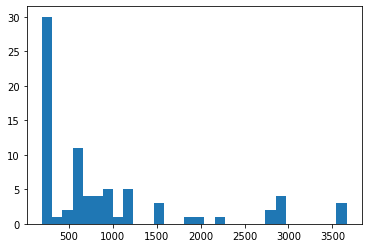

In [26]:
act_a = active_studs_checks.loc[active_studs_checks['grp'] == 'A']
plt.hist(act_a.rev,bins=30);

среднее и медианное значения

In [27]:
act_a.rev.mean()

933.5897435897435

In [28]:
act_a.rev.median()

585.0

а теперь для целевой группы. на графике снизу можем видеть что на распределении есть значительные выбросы в районе значения 1900. Возможно это какие-то регулярные платежи

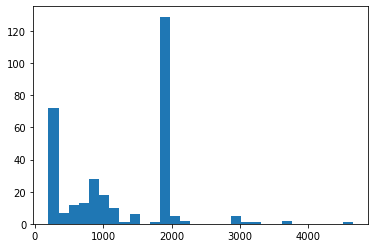

In [29]:
act_b = active_studs_checks.loc[active_studs_checks['grp'] == 'B']
plt.hist(act_b.rev,bins=30);

всего таких значений 128 из 314, более 40%

In [30]:
act_b.rev.value_counts().head()

1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
Name: rev, dtype: int64

построим график распределения без этих значений

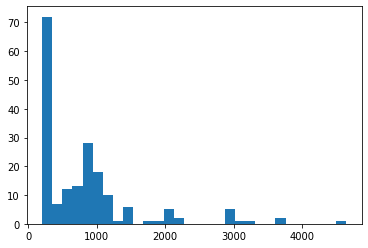

In [31]:
good_act_b = act_b[(act_b.rev != 1900.0000) & (act_b.rev != 1900.0001)]
plt.hist(good_act_b.rev, bins=30);

среднее и медианное значения без учета выбросов

In [32]:
good_act_b.rev.mean()

815.989247311828

In [33]:
good_act_b.rev.median()

690.0

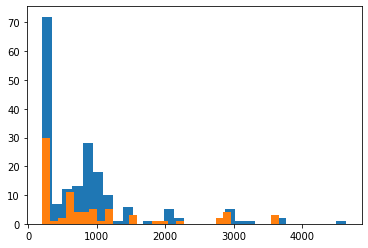

In [34]:
plt.hist(good_act_b.rev, bins = 30)
plt.hist(act_a.rev, bins=30);

можем увидеть что для контрольной группы А медианное значение 585 и 690 для В

что говорит о том, что двукратного преимущества у одной группы над другой нет, как показалось сначала

мединное значение более устойчиво к выбросам, поэтому я оценивал именно его


In [35]:
(good_act_b.rev.median()-act_a.rev.median())*100/act_a.rev.median()

17.94871794871795

тем не менее медианный чек для целевой группы больше на 18%. поэтому если перенастроить тест (взять примерно равные группы, получить большее количество данных о конверсиях, чтобы результаты получились стат занчимыми), то скорее всего результаты теста будут положительные и можно будет ввести новую механику